In [57]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [58]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [168]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
unfilt_ab = od+expand(config['lr']['cerberus']['ab'], species='human')[0] 
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]

major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

phastcons = od+config['ref']['phastcons100']['txt']

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

## GO terms for genes in different sectors

In [23]:
def do_go_thing(df, opref):
    dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human',
          'Pfam_Domains_2019']
    # bm = gp.parser.Biomart()
    # datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
    # datasets.loc[datasets.Description.str.contains('Human')]
    
    for s in df.sector.unique():
        print(s)
        desc = '{} genes'.format(s)
        odir = '{}{}_genes_GO'.format(opref, s)
        # gids = df.loc[df.sector == s, 'gid'].tolist()
        # gids = bm.query(dataset='hsapiens_gene_ensembl',
        #        attributes=['ensembl_gene_id', 'external_gene_name'],
        #        filters={'ensembl_gene_id': gids})
        # gids = gids.loc[~gids.external_gene_name.isna()]
        # gnames = gids.external_gene_name.squeeze().str.strip().tolist()
        gnames = df.loc[df.sector==s, 'gname'].tolist()
        go = gp.enrichr(gene_list=gnames,
                        gene_sets=dbs,
                        organism='Human',
                        description=desc,
                        outdir=odir,
                        cutoff=0.5)

In [18]:
# df.head()

In [19]:
source = 'obs_major'
ca = cerberus.read(cerberus_h5)
df = ca.triplets.loc[ca.triplets.source == source]

# limit to protein coding genes
gtf_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gids = gtf_df.loc[gtf_df.biotype_category=='protein_coding', 'gid_stable'].tolist()
print(len(df.index))
df = df.loc[df.gid.isin(gids)]
print(len(df.index))

26544
17433


In [20]:
for s in df.sector.unique().tolist():
    temp = df.loc[df.sector==s]
    temp.to_csv(f'{s}_obs_major_human_genes.tsv',sep='\t')

In [24]:
do_go_thing(df, 'obs_major_')

tes
simple
mixed
tss
splicing


In [45]:
def rm_go_number(df):
    df['term'] = df['Term'].str.split('\(GO', expand=True)[0]
    return df

In [46]:
# # splicing - none are significant :(
# df = pd.read_csv('obs_major_splicing_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
# df = df.sort_values(by='Adjusted P-value', ascending=True)
# n = 4
# kind = 'splicing'
# df = df.head(n)
# df = df.sort_values(by='Combined Score', ascending=False)

# df = rm_go_number(df)
# color = get_sector_colors()[0][kind]


# sns.set_context('paper', font_scale=2.2)
# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['pdf.fonttype'] = 42
# plt.figure(figsize=(3,4))
# ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set(title='GO Molecular Component')

# xlabel = 'Enrichr Combined Score'
# ylabel = 'Splicing-high genes'

# _ = ax.set(xlabel=xlabel, ylabel=ylabel)
# fname = 'obs_major_splicing_genes_GO/molecular_component_bar.pdf'
# plt.savefig(fname, dpi=500, bbox_inches='tight')

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,term
0,GO_Molecular_Function_2021,RNA polymerase II transcription regulatory reg...,384/1359,3.802729e-11,4.300886e-08,0,0,1.526051,36.614106,ZNF175;IKZF1;CCAR1;IKZF5;ELK3;SPIB;ELK4;SOX2;H...,RNA polymerase II transcription regulatory reg...
3,GO_Molecular_Function_2021,RNA binding (GO:0003723),369/1406,7.363027e-07,2.081896e-04,0,0,1.367630,19.313161,EIF4A1;RAMAC;POP1;FCF1;IFIT5;CISD2;GPATCH4;THU...,RNA binding
4,GO_Molecular_Function_2021,GDP binding (GO:0019003),30/67,1.096668e-05,2.480663e-03,0,0,3.057521,34.918878,RAB3B;RASEF;GNAI3;MIEF1;RAB22A;RAB21;RAP1B;RAB...,GDP binding


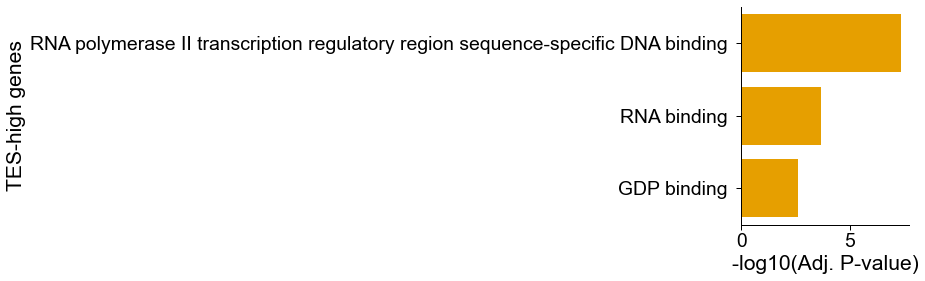

In [53]:
# tes - show molecular function
df = pd.read_csv('obs_major_tes_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
df = df.sort_values(by='Adjusted P-value', ascending=True)
n = 4
kind = 'tes'
# df = df.head(n)
df = df.iloc[[0,3,4]]
df['adj_p_val'] = -1*(np.log10(df['Adjusted P-value']))
# df = df.sort_values(by='Combined Score', ascending=False)
# df = df.sort_values(by='Combined Score', ascending=False)


df = rm_go_number(df)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
# ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax = sns.barplot(data=df, x='adj_p_val', y='term', color=color, saturation=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set(title='GO Molecular Component')

# xlabel = 'Enrichr Combined Score'
xlabel = '-log10(Adj. P-value)'
ylabel = 'TES-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_tes_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

In [35]:
# # tes - show molecular function
# df = pd.read_csv('obs_major_tes_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
# # df = df.sort_values(by='Adjusted P-value', ascending=True)
# # n = 2
# kind = 'tes'
# # df = df.head(n)
# df = df.iloc[[0,3]]

# df = df.sort_values(by='Combined Score', ascending=False)

# df = rm_go_number(df)
# color = get_sector_colors()[0][kind]


# sns.set_context('paper', font_scale=2.2)
# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['pdf.fonttype'] = 42
# plt.figure(figsize=(3,4))
# ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set(title='GO Molecular Component')

# xlabel = 'Enrichr Combined Score'
# ylabel = 'TES-high genes'

# _ = ax.set(xlabel=xlabel, ylabel=ylabel)
# fname = 'obs_major_tes_genes_GO/molecular_component_bar.pdf'
# plt.savefig(fname, dpi=500, bbox_inches='tight')

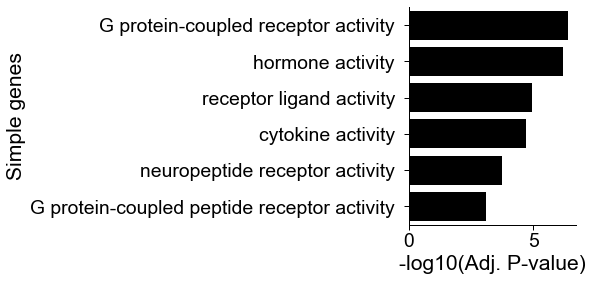

In [54]:
# simple - show molecular function
df = pd.read_csv('obs_major_simple_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 6
kind = 'simple'
df = df.sort_values(by='Adjusted P-value', ascending=True)
df = df.head(n)

df = rm_go_number(df)
df['adj_p_val'] = -1*(np.log10(df['Adjusted P-value']))

# df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
# ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax = sns.barplot(data=df, x='adj_p_val', y='term', color=color, saturation=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set(title='GO Molecular Component')

# xlabel = 'Enrichr Combined Score'
ylabel = 'Simple genes'
xlabel = '-log10(Adj. P-value)'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_simple_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

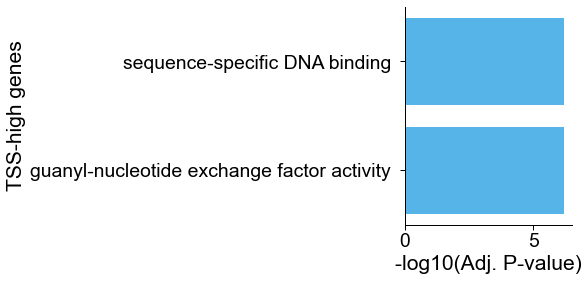

In [55]:
# tss - show molecular function
df = pd.read_csv('obs_major_tss_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 6
kind = 'tss'


df = rm_go_number(df)
# df = df.sort_values(by='Combined Score', ascending=False)
df = df.sort_values(by='Adjusted P-value', ascending=True)
# import pdb; pdb.set_trace()
df = df.iloc[[0,1]]
df = df.head(n)
# df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]
df['adj_p_val'] = -1*(np.log10(df['Adjusted P-value']))

sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
# ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax = sns.barplot(data=df, x='adj_p_val', y='term', color=color, saturation=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set(title='GO Molecular Component')

# xlabel = 'Enrichr Combined Score'
xlabel = '-log10(Adj. P-value)'
ylabel = 'TSS-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_tss_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

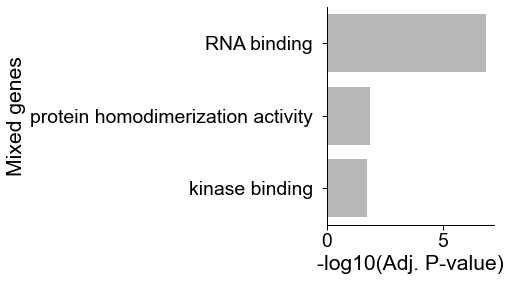

In [57]:
# mixed - show molecular function
df = pd.read_csv('obs_major_mixed_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
df = df.sort_values(by='Adjusted P-value', ascending=True)

n = 3
kind = 'mixed'
df = df.head(n)

df = rm_go_number(df)
df['adj_p_val'] = -1*(np.log10(df['Adjusted P-value']))
# df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
# ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax = sns.barplot(data=df, x='adj_p_val', y='term', color=color, saturation=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set(title='GO Molecular Component')

# xlabel = 'Enrichr Combined Score'
xlabel = '-log10(Adj. P-value)'
ylabel = 'Mixed genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_mixed_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

# non Go-term characteristics

In [141]:
gene_subset='protein_coding'
source = 'obs_major'

In [142]:
gtf_df = pr.read_gtf(cerb_gtf,
                     rename_attr=True,
                     duplicate_attr=True)
ca = cerberus.read(cerberus_h5)
biotype_info, _, _ = get_gtf_info(add_stable_gid=True)
gids = biotype_info.loc[biotype_info.biotype==gene_subset, 'gid_stable'].tolist()
ca.triplets = ca.triplets.loc[ca.triplets.gid.isin(gids)]

In [143]:
def get_sector_disp_colors(cats=None):
    tss = '#56B4E9'
    tes = '#E69F00'
    splicing = '#CC79A7'
    simple = '#000000'
    c_dict = {'TSS': tss,
              'Splicing': splicing,
              'TES': tes,
              'Simple': simple,
              'Mixed': '#b7b7b7'}
    order = ['TSS', 'Splicing', 'TES', 'Mixed', 'Simple']
    return c_dict, order
c_dict, order = get_sector_colors()
disp_order = ['TSS', 'Splicing', 'TES', 'Mixed', 'Simple']
disp_map = {}
for o in order:
    if o == 'tes' or o == 'tss':
        disp_map[o] = o.upper()
    else:
        disp_map[o] = o.capitalize()
c_dict, order = get_sector_disp_colors()

In [144]:
sns.set_context('paper', font_scale=1.8)

In [145]:
# import seaborn as sns
# titanic = sns.load_dataset('titanic')
# sns.boxplot(data=titanic, x="class", y="age", hue="alive", fill=False, gap=.1)


## Mean total intron length

In [149]:
introns = gtf_df.features.introns(by='transcript').df
introns['len'] = (introns.Start-introns.End).abs()
introns = introns[['gene_id', 'transcript_id', 'len']].groupby(['gene_id', 'transcript_id']).sum().reset_index()
introns = introns[['gene_id', 'len']].groupby('gene_id').mean().reset_index().rename({'len':'mean_intron_len'}, axis=1)
introns = cerberus.add_stable_gid(introns)

df = ca.triplets.loc[ca.triplets.source==source].copy()
df = df.merge(introns, how='left', left_on='gid', right_on='gene_id')

df['log_mean_intron_len'] = np.log2(df['mean_intron_len'])


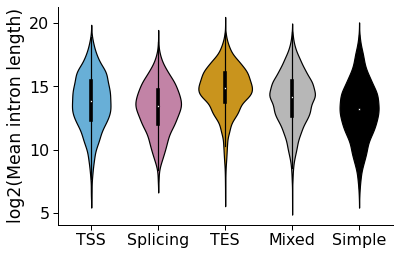

In [150]:
df['sect_disp'] = df.sector.map(disp_map)
ax = sns.violinplot(df, y='log_mean_intron_len', x='sect_disp', order=order, palette=c_dict, fill=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xlabel = ''
ylabel = 'log2(Mean intron length)'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

plt.savefig('figures/intron_len_per_sect.pdf', bbox_inches='tight')

In [151]:
df.to_csv('sector_char_tsvs/intron_len_per_sect.tsv', sep='\t')

In [152]:
# stats test
for i in df.sector.unique():
    for j in df.sector.unique():
        if i==j: continue
        x = df.loc[df.sector==i, 'log_mean_intron_len'].dropna().tolist()
        y = df.loc[df.sector==j, 'log_mean_intron_len'].dropna().tolist()
        stat, pval = st.mannwhitneyu(x,y)
        print(f'{i} vs. {j} stat: {stat}, pval: {pval}')

tes vs. simple stat: 5788978.0, pval: 1.3068854405388755e-165
tes vs. mixed stat: 19012073.5, pval: 1.9584997821056692e-90
tes vs. tss stat: 5217845.0, pval: 6.506396779342347e-67
tes vs. splicing stat: 3993296.0, pval: 1.7917561924055463e-120
simple vs. tes stat: 2274242.0, pval: 1.3068854405388755e-165
simple vs. mixed stat: 5521501.0, pval: 2.5647509812821128e-54
simple vs. tss stat: 1573581.5, pval: 1.144263310596053e-19
simple vs. splicing stat: 1224691.5, pval: 0.007881027972142327
mixed vs. tes stat: 12024426.5, pval: 1.9584997821056692e-90
mixed vs. simple stat: 8801324.0, pval: 2.5647509812821128e-54
mixed vs. tss stat: 7697399.5, pval: 9.266251598994358e-05
mixed vs. splicing stat: 5946503.0, pval: 2.231635749703134e-29
tss vs. tes stat: 2979135.0, pval: 6.506396779342347e-67
tss vs. simple stat: 2209187.5, pval: 1.144263310596053e-19
tss vs. mixed stat: 6863025.5, pval: 9.266251598994358e-05
tss vs. splicing stat: 1484840.5, pval: 4.4053663455744546e-10
splicing vs. tes stat

In [167]:
df = pd.read_csv('sector_char_tsvs/intron_len_per_sect.tsv', sep='\t')
temp = df.loc[~df.log_mean_intron_len.isnull()]
a = temp.n_tes.tolist()
b = temp.log_mean_intron_len.tolist()
st.pearsonr(a,b)

(0.3336652750564758, 0.0)

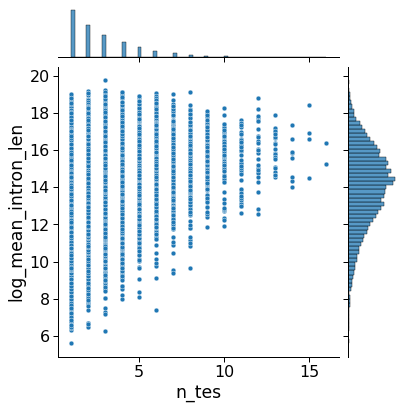

In [165]:
sns.jointplot(df, x='n_tes', y='log_mean_intron_len')

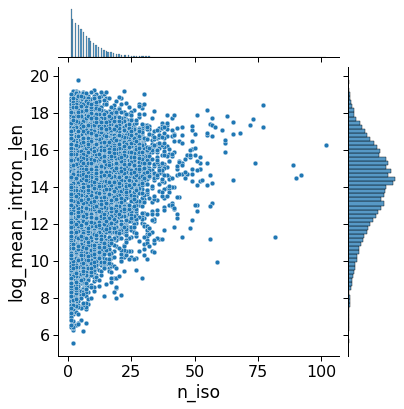

In [153]:
sns.jointplot(df, x='n_iso', y='log_mean_intron_len')

In [154]:
temp = df.loc[~df.log_mean_intron_len.isnull()]
a = temp.n_iso.tolist()
b = temp.log_mean_intron_len.tolist()
st.pearsonr(a,b)

(0.19392806696604925, 2.2768058552219257e-142)

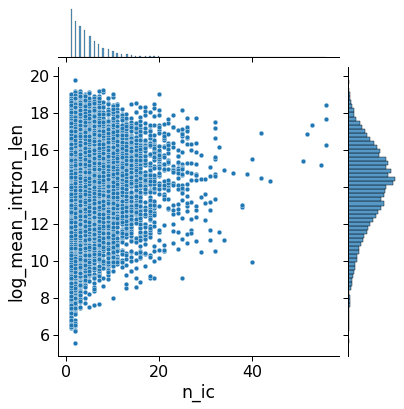

In [155]:
sns.jointplot(df, x='n_ic', y='log_mean_intron_len')

In [156]:
temp = df.loc[~df.log_mean_intron_len.isnull()]
a = temp.n_ic.tolist()
b = temp.log_mean_intron_len.tolist()
st.pearsonr(a,b)

(0.125172729808541, 9.014313448564719e-60)

## Mean mean intron length 
mean(Mean intron length of introns in each transcript)

In [157]:
introns = gtf_df.features.introns(by='transcript').df
introns['len'] = (introns.Start-introns.End).abs()
introns = introns[['gene_id', 'transcript_id', 'len']].groupby(['gene_id', 'transcript_id']).mean().reset_index()
introns = introns[['gene_id', 'len']].groupby('gene_id').mean().reset_index().rename({'len':'mean_intron_len'}, axis=1)
introns = cerberus.add_stable_gid(introns)

df = ca.triplets.loc[ca.triplets.source==source].copy()
df = df.merge(introns, how='left', left_on='gid', right_on='gene_id')

df['log_mean_intron_len'] = np.log2(df['mean_intron_len'])


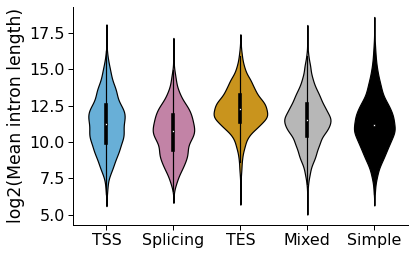

In [158]:
df['sect_disp'] = df.sector.map(disp_map)
ax = sns.violinplot(df, y='log_mean_intron_len', x='sect_disp', order=order, palette=c_dict, fill=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xlabel = ''
ylabel = 'log2(Mean intron length)'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

plt.savefig('figures/mean_mean_intron_len_per_sect.pdf', bbox_inches='tight')

In [159]:
df.to_csv('sector_char_tsvs/mean_mean_intron_len_per_sect.tsv', sep='\t')

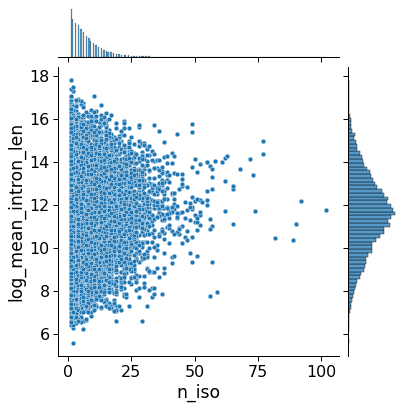

In [160]:
sns.jointplot(df, x='n_iso', y='log_mean_intron_len')

In [161]:
temp = df.loc[~df.log_mean_intron_len.isnull()]
a = temp.n_iso.tolist()
b = temp.log_mean_intron_len.tolist()
st.pearsonr(a,b)

(0.06519939968801983, 2.480545791531897e-17)

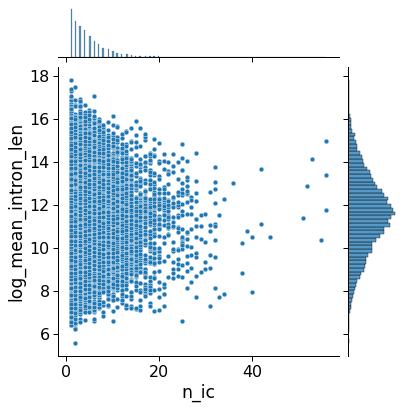

In [162]:
sns.jointplot(df, x='n_ic', y='log_mean_intron_len')

In [163]:
temp = df.loc[~df.log_mean_intron_len.isnull()]
a = temp.n_ic.tolist()
b = temp.log_mean_intron_len.tolist()
st.pearsonr(a,b)

(-0.04826632385377967, 3.697539616980067e-10)

## Mean number of introns

In [73]:
# gtf_df = pr.PyRanges(gtf_df)
# introns = pr.PyRanges(gtf_df).features.introns(by='transcript').df
introns = gtf_df.features.introns(by='transcript').df
introns['len'] = (introns.Start-introns.End).abs()
introns = introns[['gene_id', 'transcript_id', 'len']].groupby(['gene_id', 'transcript_id']).count().reset_index()
introns = introns[['gene_id', 'len']].groupby('gene_id').mean().reset_index().rename({'len':'mean_n_intron'}, axis=1)

In [74]:
introns = cerberus.add_stable_gid(introns)
df = ca.triplets.loc[ca.triplets.source==source].copy()
df = df.merge(introns, how='left', left_on='gid', right_on='gene_id')
df.loc[df.mean_n_intron.isnull()]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,gene_id,mean_n_intron
583,obs_major,ENSG00000043591,3.0,1.0,1.0,3.0,0.500000,0.666667,0.222222,0.111111,tss,ADRB1,NaN,NaN,NaN,NaN
711,obs_major,ENSG00000054598,5.0,3.0,1.0,11.0,0.250000,0.606061,0.363636,0.030303,tss,FOXC1,NaN,NaN,NaN,NaN
2504,obs_major,ENSG00000101898,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,MCTS2P,NaN,NaN,NaN,NaN
2545,obs_major,ENSG00000102128,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,RAB40AL,NaN,NaN,NaN,NaN
3758,obs_major,ENSG00000111432,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,FZD10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17391,obs_major,ENSG00000284546,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SSU72P3,NaN,NaN,NaN,NaN
17393,obs_major,ENSG00000284631,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SCYGR4,NaN,NaN,NaN,NaN
17397,obs_major,ENSG00000284730,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TMDD1,NaN,NaN,NaN,NaN
17410,obs_major,ENSG00000284976,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,ENSG00000284976,NaN,NaN,NaN,NaN


In [75]:

pairs = list(itertools.combinations(df.sector.unique().tolist(), 2))
c1 = [c[0] for c in pairs]
c2 = [c[1] for c in pairs]

In [76]:
df.to_csv('sector_char_tsvs/mean_n_intron.tsv', sep='\t')

<AxesSubplot:xlabel='sector', ylabel='mean_n_intron'>

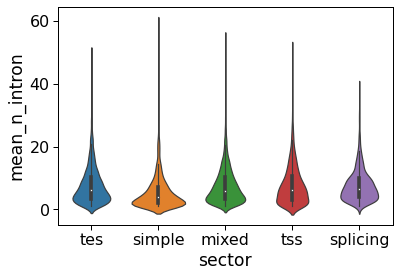

In [77]:
sns.violinplot(df, y='mean_n_intron', x='sector')

In [78]:
# t test
for sect1, sect2 in zip(c1, c2):
    v1 = df.loc[df.sector==sect1, 'mean_n_intron'].tolist()
    v2 = df.loc[df.sector==sect2, 'mean_n_intron'].tolist()
    result = st.ttest_ind(v1, v2, nan_policy='omit', alternative='two-sided')
    p = result.pvalue
    stat = result.statistic
    # print(f'{sect1} vs. {sect2}: p={p}, stat={stat}')
    print(f'{sect1} vs. {sect2}: p={p}')
    print()

tes vs. simple: p=3.254261683517977e-48

tes vs. mixed: p=0.25400575798433617

tes vs. tss: p=0.5744355502997067

tes vs. splicing: p=0.8257476676115615

simple vs. mixed: p=4.127243393931905e-50

simple vs. tss: p=9.573420727277095e-38

simple vs. splicing: p=1.9908112273666033e-35

mixed vs. tss: p=0.14028531454516655

mixed vs. splicing: p=0.3209661710884122

tss vs. splicing: p=0.7973014138495746



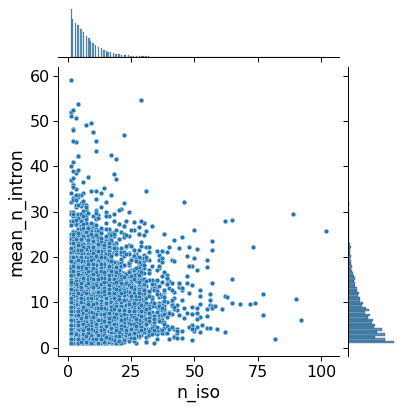

In [79]:
sns.jointplot(df, x='n_iso', y='mean_n_intron')

In [80]:
temp = df.loc[~df.mean_n_intron.isnull()]
a = temp.n_iso.tolist()
b = temp.mean_n_intron.tolist()
st.pearsonr(a,b)

(0.2131358254056187, 3.115083238487342e-172)

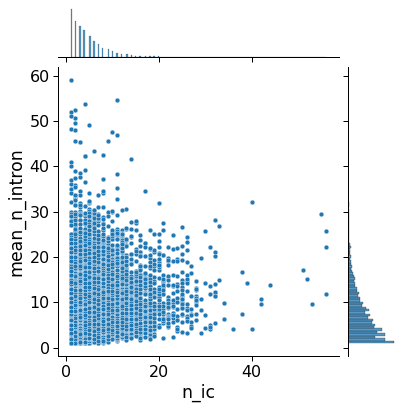

In [81]:
sns.jointplot(df, x='n_ic', y='mean_n_intron')

In [82]:
temp = df.loc[~df.mean_n_intron.isnull()]
a = temp.n_ic.tolist()
b = temp.mean_n_intron.tolist()
st.pearsonr(a,b)

(0.2485143833254406, 2.1587264141339258e-235)

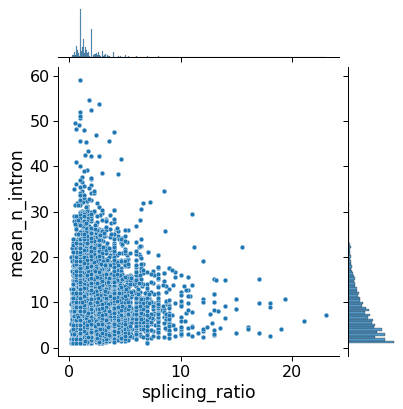

In [83]:
sns.jointplot(df, x='splicing_ratio', y='mean_n_intron')

In [84]:
temp = df.loc[~df.mean_n_intron.isnull()]
a = temp.splicing_ratio.tolist()
b = temp.mean_n_intron.tolist()
st.pearsonr(a,b)

(0.12579450814764964, 2.3614718277027131e-60)

## Exon len % 3 (internal exons only)

In [85]:
# gtf_df = gtf_df.df
exons = gtf_df.df.loc[gtf_df.Feature=='exon']

In [86]:
# remove monoexonic or two-exon transcripts
temp = exons[['transcript_id', 'Start']].groupby('transcript_id').count().reset_index().rename({'Start': 'n_exons'}, axis=1)
temp = temp.loc[temp.n_exons>2]
exons = exons.loc[exons.transcript_id.isin(temp.transcript_id.tolist())]

In [87]:
exons = exons.reset_index(drop=True)


In [88]:
# restrict to internal exons
drop_inds = exons[['transcript_id']].drop_duplicates(keep='first').index.tolist()+\
            exons[['transcript_id']].drop_duplicates(keep='last').index.tolist()
keep_inds = list(set(exons.index.tolist())-set(drop_inds))
exons = exons.loc[keep_inds]

# compute len of exons
exons['exon_len'] = (exons.Start-exons.End).abs()

In [89]:
exons['exon_len_mod_3'] = exons.exon_len % 3 
exons['frame_preserving'] = exons.exon_len % 3 == 0

<AxesSubplot:xlabel='exon_len_mod_3', ylabel='Count'>

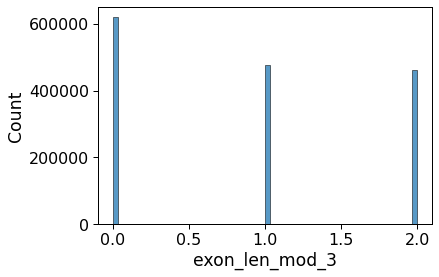

In [90]:
sns.histplot(data=exons, x='exon_len_mod_3')

In [91]:
# % of frame preserving exons / gene
keep_cols = ['Chromosome', 'Start', 'End', 'Strand', 'gene_id', 'exon_len_mod_3', 'frame_preserving']
exons = exons[keep_cols].drop_duplicates()

exons.head()

# # total number of exons
# temp = exons['gene_id', 'Start'].groupby('gene_id').count().reset_index().rename({'Start':'n_exons'}, axis=1)
# exons = exons.merge(temp, how='left', on='gene_id')

# # numb
exons = exons[['gene_id', 'frame_preserving']].groupby('gene_id').agg({'frame_preserving': ['count', 'sum']}).reset_index().rename({'count':'n_exons', 
                                                                                                                                   'sum':'n_frame_preserving_exons'}, axis=1)

In [92]:
[col[1] for col in exons.columns]
exons.columns = ['gene_id', 'n_exons', 'n_frame_preserving_exons']

In [93]:
exons = cerberus.add_stable_gid(exons)
exons['perc_frame_pres_exons'] = (exons.n_frame_preserving_exons/exons.n_exons)*100

In [94]:
df = ca.triplets.loc[ca.triplets.source==source].copy()
df = df.merge(exons, how='left', left_on='gid', right_on='gene_id')
df.loc[df.perc_frame_pres_exons.isnull()]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,gene_id,n_exons,n_frame_preserving_exons,perc_frame_pres_exons
33,obs_major,ENSG00000003137,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,CYP26B1,NaN,NaN,NaN,NaN,NaN,NaN
583,obs_major,ENSG00000043591,3.0,1.0,1.0,3.0,0.500000,0.666667,0.222222,0.111111,tss,ADRB1,NaN,NaN,NaN,NaN,NaN,NaN
711,obs_major,ENSG00000054598,5.0,3.0,1.0,11.0,0.250000,0.606061,0.363636,0.030303,tss,FOXC1,NaN,NaN,NaN,NaN,NaN,NaN
1504,obs_major,ENSG00000081818,1.0,2.0,2.0,3.0,1.333333,0.230769,0.461538,0.307692,mixed,PCDHB4,NaN,NaN,NaN,NaN,NaN,NaN
1506,obs_major,ENSG00000081853,2.0,2.0,2.0,2.0,1.000000,0.400000,0.400000,0.200000,mixed,PCDHGA2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17403,obs_major,ENSG00000284797,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000284797,NaN,NaN,NaN,NaN,NaN,NaN
17406,obs_major,ENSG00000284895,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000284895,NaN,NaN,NaN,NaN,NaN,NaN
17410,obs_major,ENSG00000284976,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,ENSG00000284976,NaN,NaN,NaN,NaN,NaN,NaN
17412,obs_major,ENSG00000285025,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000285025,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
df.to_csv('sector_char_tsvs/perc_frame_pres_exons.tsv', sep='\t')

<AxesSubplot:xlabel='sector', ylabel='perc_frame_pres_exons'>

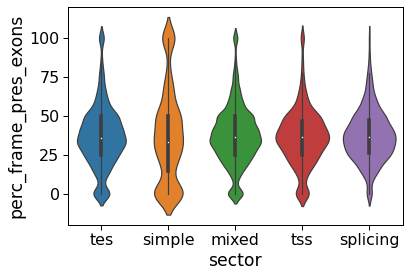

In [96]:
sns.violinplot(df, y='perc_frame_pres_exons', x='sector')

<AxesSubplot:xlabel='sector', ylabel='perc_frame_pres_exons'>

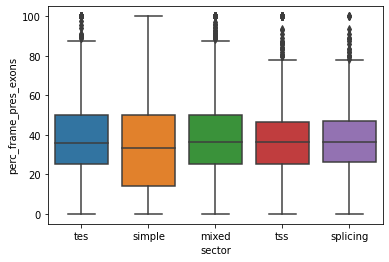

In [43]:
sns.boxplot(df, y='perc_frame_pres_exons', x='sector')

In [98]:
df.loc[df.gname=='ELN', 'perc_frame_pres_exons']

646    93.478261
Name: perc_frame_pres_exons, dtype: float64

In [99]:
# t test
for sect1, sect2 in zip(c1, c2):
    v1 = df.loc[df.sector==sect1, 'perc_frame_pres_exons'].tolist()
    v2 = df.loc[df.sector==sect2, 'perc_frame_pres_exons'].tolist()
    result = st.ttest_ind(v1, v2, nan_policy='omit', alternative='two-sided')
    p = result.pvalue
    stat = result.statistic
    # print(f'{sect1} vs. {sect2}: p={p}, stat={stat}')
    print(f'{sect1} vs. {sect2}: p={p}')
    print()

tes vs. simple: p=0.3876633401856825

tes vs. mixed: p=0.22517810109563505

tes vs. tss: p=0.3502430180138508

tes vs. splicing: p=0.6538876207861293

simple vs. mixed: p=0.8286708735544054

simple vs. tss: p=0.18325748514935636

simple vs. splicing: p=0.7357838265629915

mixed vs. tss: p=0.04571880501206198

mixed vs. splicing: p=0.7380220917909571

tss vs. splicing: p=0.21447766233642798



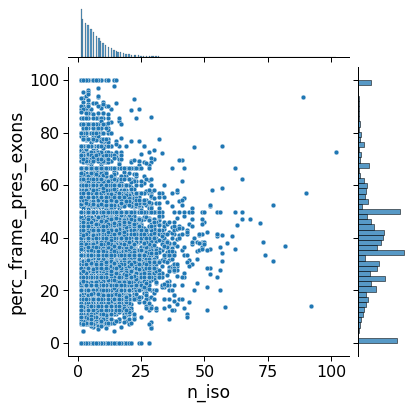

In [100]:
sns.jointplot(df, x='n_iso', y='perc_frame_pres_exons')

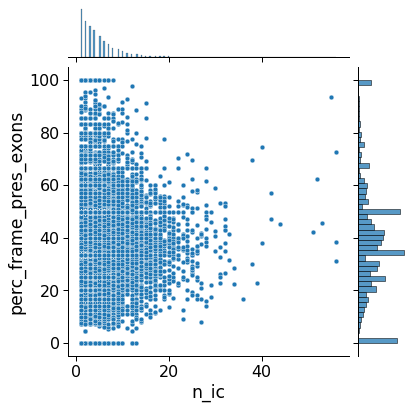

In [101]:
sns.jointplot(df, x='n_ic', y='perc_frame_pres_exons')

In [102]:
temp = df.loc[~df.perc_frame_pres_exons.isnull()]
a = temp.n_ic.tolist()
b = temp.perc_frame_pres_exons.tolist()
st.pearsonr(a,b)

(0.014310791090000146, 0.06570419715604442)

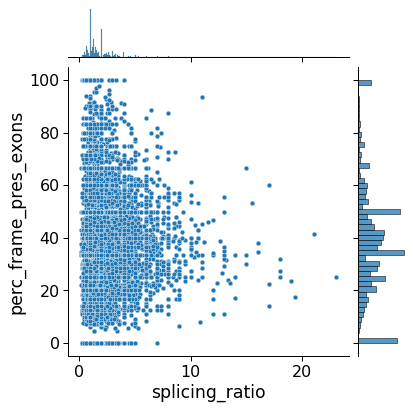

In [103]:
sns.jointplot(df, x='splicing_ratio', y='perc_frame_pres_exons')

In [104]:
temp = df.loc[~df.perc_frame_pres_exons.isnull()]
a = temp.splicing_ratio.tolist()
b = temp.perc_frame_pres_exons.tolist()
st.pearsonr(a,b)

(0.0044815646366178526, 0.5643961422406726)

## Conservation

In [105]:
# "parameters"
min_cons_score = 250

In [109]:
# read conserved elements in, threshold for a certain score
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons = cons[['Chromosome', 'Start', 'End', 'score']]
cons = cons.loc[cons.score >= min_cons_score]
# sns.displot(cons, x='score', kind='kde')
cons = pr.PyRanges(cons)

In [112]:
# read gtf, limit to relevant columns
# only look at exons, calc exon len
gtf_df = pr.read_gtf(cerb_gtf, duplicate_attr=True, rename_attr=True).as_df()
gtf_df = gtf_df[['Chromosome', 'Start', 'End', 'gene_name',
                 'gene_id', 'transcript_id', 'Feature']]
gtf_df = gtf_df.loc[gtf_df.Feature=='exon']
gtf_df['exon_len'] = (gtf_df.Start-gtf_df.End).abs()

In [113]:
gtf_df = pr.PyRanges(gtf_df)
gtf_df = gtf_df.join(cons, report_overlap=True)

In [114]:
gtf_df = gtf_df.df

# get len covered in each exon
keep_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id', 'exon_len', 'Overlap']
gb_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id', 'exon_len']
temp = gtf_df[keep_cols].groupby(gb_cols, observed=True).sum().reset_index().rename({'Overlap': 'cons_len'}, axis=1)

In [115]:
# get total len of transcript and len covered of each transcript 
keep_cols = ['gene_name', 'gene_id', 'transcript_id', 'exon_len', 'cons_len']
gb_cols = ['gene_name', 'gene_id', 'transcript_id']
temp = temp[keep_cols].groupby(gb_cols,observed=True).sum().reset_index().rename({'exon_len': 't_len'}, axis=1)

In [116]:
# now get median % exonic conservation per gene
temp['perc_cons'] = (temp['cons_len']/temp['t_len'])*100
keep_cols = ['gene_name', 'gene_id', 'perc_cons']
gb_cols = ['gene_name', 'gene_id']
# temp = temp[keep_cols].groupby(gb_cols, observed=True).median().reset_index().rename({'perc_cons':'med_perc_cons'}, axis=1)
temp = temp[keep_cols].groupby(gb_cols, observed=True).mean().reset_index().rename({'perc_cons':'mean_perc_cons'}, axis=1)

In [117]:
temp = cerberus.add_stable_gid(temp)

In [118]:
# merge median % conservation w/ each gene
ca = cerberus.read(cerberus_h5)

In [119]:
df = ca.triplets.loc[ca.triplets.source==source]

In [120]:
df = df.merge(temp, how='left', left_on='gid', right_on='gene_id')

In [121]:
# df.loc[df.med_perc_cons.isnull()]
df.loc[df.mean_perc_cons.isnull()]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,gene_name,gene_id,mean_perc_cons
147,obs_major,ENSG00000006659,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,simple,LGALS14,NaN,NaN,NaN,NaN,NaN
218,obs_major,ENSG00000008517,3.0,3.0,18.0,23.0,6.0,0.250000,0.250000,0.500000,mixed,IL32,NaN,NaN,NaN,NaN,NaN
4912,obs_major,ENSG00000120664,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,simple,SPART-AS1,NaN,NaN,NaN,NaN,NaN
6265,obs_major,ENSG00000132204,2.0,2.0,3.0,3.0,1.5,0.363636,0.363636,0.272727,mixed,LINC00470,NaN,NaN,NaN,NaN,NaN
6378,obs_major,ENSG00000132832,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,simple,ENSG00000132832,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26518,obs_major,ENSG00000285829,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,simple,ENSG00000285829,NaN,NaN,NaN,NaN,NaN
26530,obs_major,ENSG00000285886,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,simple,ENSG00000285886,NaN,NaN,NaN,NaN,NaN
26536,obs_major,ENSG00000285933,2.0,2.0,1.0,3.0,0.5,0.444444,0.444444,0.111111,mixed,ENSG00000285933,NaN,NaN,NaN,NaN,NaN
26538,obs_major,ENSG00000285958,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,simple,ENSG00000285958,NaN,NaN,NaN,NaN,NaN


In [122]:
len(df.index)

26544

In [124]:
df.to_csv('sector_char_tsvs/mean_perc_cons.tsv', sep='\t')


<AxesSubplot:xlabel='sector', ylabel='mean_perc_cons'>

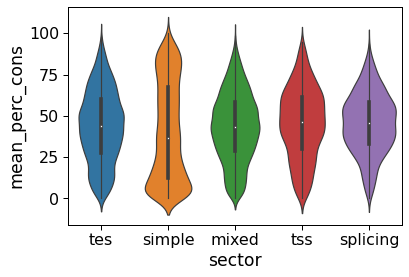

In [123]:
sns.violinplot(df, y='mean_perc_cons', x='sector')

<AxesSubplot:xlabel='sector', ylabel='mean_perc_cons'>

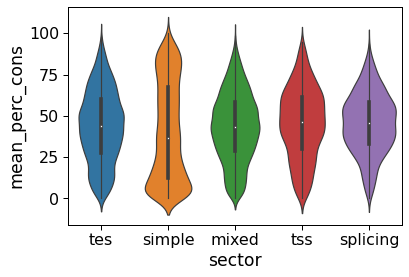

In [125]:
sns.violinplot(df, y='mean_perc_cons', x='sector')

In [126]:

pairs = list(itertools.combinations(df.sector.unique().tolist(), 2))
c1 = [c[0] for c in pairs]
c2 = [c[1] for c in pairs]

In [127]:
# t test
for sect1, sect2 in zip(c1, c2):
    v1 = df.loc[df.sector==sect1, 'mean_perc_cons'].tolist()
    v2 = df.loc[df.sector==sect2, 'mean_perc_cons'].tolist()
    result = st.ttest_ind(v1, v2, nan_policy='omit', alternative='two-sided')
    p = result.pvalue
    stat = result.statistic
    # print(f'{sect1} vs. {sect2}: p={p}, stat={stat}')
    print(f'{sect1} vs. {sect2}: p={p}')
    print()

tes vs. simple: p=7.009701364899275e-11

tes vs. mixed: p=0.17557722823357128

tes vs. tss: p=0.0016817096040828404

tes vs. splicing: p=0.0046997630622061986

simple vs. mixed: p=9.290955263177582e-12

simple vs. tss: p=7.453390611505443e-14

simple vs. splicing: p=1.1754106072291476e-09

mixed vs. tss: p=4.901945834311982e-06

mixed vs. splicing: p=8.700946140024404e-05

tss vs. splicing: p=0.8841452922485074



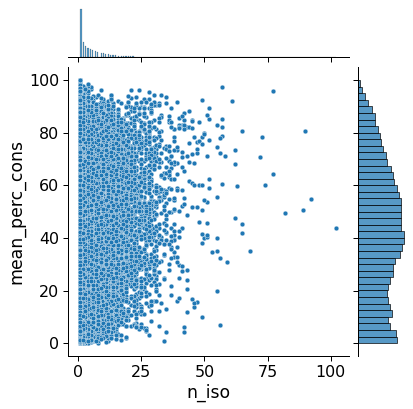

In [128]:
sns.jointplot(df, x='n_iso', y='mean_perc_cons')

In [129]:
temp = df.loc[~df.mean_perc_cons.isnull()]
a = temp.n_iso.tolist()
b = temp.mean_perc_cons.tolist()
st.pearsonr(a,b)

(0.15260110416330444, 3.301508194398442e-131)

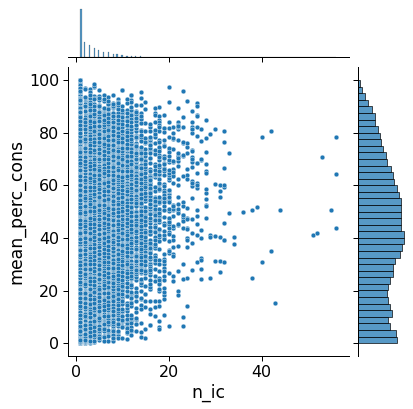

In [130]:
sns.jointplot(df, x='n_ic', y='mean_perc_cons')

In [131]:
temp = df.loc[~df.mean_perc_cons.isnull()]
a = temp.n_ic.tolist()
b = temp.mean_perc_cons.tolist()
st.pearsonr(a,b)

(0.1489455494316861, 5.064057287189029e-125)

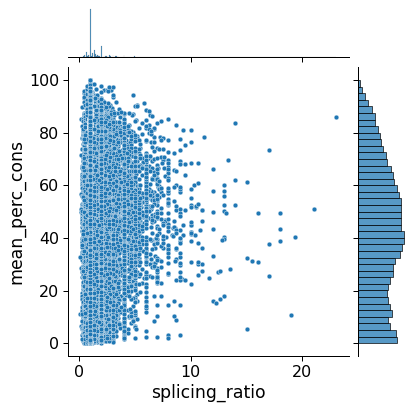

In [132]:
sns.jointplot(df, x='splicing_ratio', y='mean_perc_cons')

In [133]:
temp = df.loc[~df.mean_perc_cons.isnull()]
a = temp.splicing_ratio.tolist()
b = temp.mean_perc_cons.tolist()
st.pearsonr(a,b)

(0.07968659877710933, 8.357005439326828e-37)